## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [4]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 49
Number of winter, summer and annual samples: 6549
Number of annual samples: 3186
Number of winter samples: 3363
Number of summer samples: 0


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

In [5]:
display(data_wgms[data_wgms['POINT_BALANCE'] < -15].head(10))

POINT_ELEVATION  POINT_LAT  POINT_LON DATA_MODIFICATION  FROM_DATE  \
1752            835.0  64.683333    -15.921               NaN   19990922   
5048            835.0  64.683333    -15.921               NaN   19990922   

       TO_DATE  POINT_BALANCE  PERIOD    YEAR           RGIId      aspect  \
1752  20001007        -20.626  annual  2000.0  RGI60-06.00377  336.755483   
5048  20000503        -15.457  winter  2000.0  RGI60-06.00377  336.755483   

         slope        topo  hugonnet_dhdt  consensus_ice_thickness   millan_v  \
1752  2.363665  768.701172      -5.091004                351.13324  12.260718   
5048  2.363665  768.701172      -5.091004                351.13324  12.260718   

           GLACIER                        POINT_ID  
1752  Bruarjoekull  Bruarjoekull_2000.0_annual_Bru  
5048  Bruarjoekull  Bruarjoekull_2000.0_winter_Bru

## Input data:
### Input dataset:

In [5]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))
"""
data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),
    axis=1)
data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                          data=data_monthly,
                                          random_seed=cfg.seed,
                                          meta_data_columns=cfg.metaData)
"""

2025-09-07 20:36:57,610 - INFO - Loaded preprocessed data.
2025-09-07 20:36:57,611 - INFO - Number of monthly rows: 56209
2025-09-07 20:36:57,618 - INFO - Number of annual samples: 34915
2025-09-07 20:36:57,623 - INFO - Number of winter samples: 21294


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  1989.0 -18.595688  64.790063           0.45       1094.738918   
1  1989.0 -18.595688  64.790063           0.45       1094.738918   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            -45.138918           1049.6  RGI60-06.00234   
1            -45.138918           1049.6  RGI60-06.00234   

                                            POINT_ID  ID  ...   millan_v  \
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   
1  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   

        t2m        tp      slhf      sshf       ssrd      fal        str  \
0 -4.787933  0.003747  198886.0  590722.0  3990646.0  0.84564 -1779436.0   
1 -5.262054  0.003766  306376.0  576896.0   883468.0  0.84690 -1458576.0   

        u10       v10  
0 -0.590102  0.603381  
1  0.129348  2.214950  

[2 rows x 28 columns]

'\ndata_monthly[\'GLWD_ID\'] = data_monthly.apply(\n    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),\n    axis=1)\ndata_monthly[\'GLWD_ID\'] = data_monthly[\'GLWD_ID\'].astype(str)\n\ndataloader_gl = mbm.dataloader.DataLoader(cfg,\n                                          data=data_monthly,\n                                          random_seed=cfg.seed,\n                                          meta_data_columns=cfg.metaData)\n'

## Blocking on glaciers:

In [7]:
# These are the two icecaps to the west
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

array(['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296'], dtype=object)

In [7]:
"""
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']
"""
"""
# 50%
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328',
                    'Tungnaarjoekull', 'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Oeldufellsjoekull',
                    'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340',
                    'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00320', 'Hagafellsjoekull East (Langjoekull S Dome)',
                    'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292',
                    'RGI60-06.00232', 'RGI60-06.00478', 'Mulajoekull', 'RGI60-06.00301', 'RGI60-06.00413',
                    'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409',
                    'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306',
                    'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']

"""
"""
# 5-10%
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328',
                 'Hagafellsjoekull West', 'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Koeldukvislarjoekull',
                 'Oeldufellsjoekull', 'Skeidararjoekull', 'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359',
                 'RGI60-06.00340', 'Bruarjoekull', 'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00238', 'RGI60-06.00320',
                 'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00232',
                 'RGI60-06.00301', 'RGI60-06.00413', 'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228',
                 'RGI60-06.00409', 'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306',
                 'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']
"""

# about 75%
test_glaciers = ['RGI60-06.00311', 'RGI60-06.00305', 'Thjorsarjoekull (Hofsjoekull E)','RGI60-06.00445',
                 'RGI60-06.00474','RGI60-06.00425','RGI60-06.00480','Dyngjujoekull', 'RGI60-06.00478',
                 'Koeldukvislarjoekull', 'Oeldufellsjoekull', 'RGI60-06.00350', 'RGI60-06.00340']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 12580
Size of train data: 43629
Percentage of test size: 28.83%
Train glaciers: (34) ['Breidamerkurjoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Hagafellsjoekull West' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Skeidararjoekull' 'Slettjoekull West'
 'RGI60-06.00466' 'RGI60-06.00411' 'RGI60-06.00302' 'RGI60-06.00359'
 'Bruarjoekull' 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238'
 'RGI60-06.00320' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00342' 'RGI60-06.00465' 'RGI60-06.00294' 'RGI60-06.00292'
 'RGI60-06.00232' 'Mulajoekull' 'RGI60-06.00301' 'RGI60-06.00413'
 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349'
 'RGI60-06.00422' 'RGI60-06.00306' 'RGI60-06.00479' 'RGI60-06.00296']
Test glaciers: (13) ['Thjorsarjoekull (Hofsjoekull E)' 'Dyngjujoekull' 'Koeldukvislarjoekull'
 'Oeldufellsjoekull' 'RGI60-06.00340' 'RGI60-06.00480' 'RGI60-06.00478'
 'RGI60-06.00311' 'RGI60-06.00350' 'RGI60-06.00305' 'RGI60-06.00425'
 'RGI6

In [8]:
from scipy.stats import ks_2samp

print("Train rows:", len(data_train), "Test rows:", len(data_test),
      "Ratio train/test rows ≈", round(len(data_train)/max(1,len(data_test)),2))
print("Train glaciers:", len(train_glaciers), "Test glaciers:", len(test_glaciers))

features = ['ELEVATION_DIFFERENCE', 't2m', 'ssrd', 'POINT_LAT', 'POINT_LON']   # extend if needed

# 4) Diagnostics: KS test for each feature
print("\nKS p-values (train vs test) for key features:")
for f in features:
    p = ks_2samp(data_train[f].dropna(), data_test[f].dropna()).pvalue
    print(f, "KS p:", p, "train mean/std:", data_train[f].mean(), data_train[f].std(),
          "test mean/std:", data_test[f].mean(), data_test[f].std())

Train rows: 43629 Test rows: 12580 Ratio train/test rows ≈ 3.47
Train glaciers: 34 Test glaciers: 13

KS p-values (train vs test) for key features:
ELEVATION_DIFFERENCE KS p: 4.652773523645322e-180 train mean/std: 64.87235949502555 180.53436641660196 test mean/std: 76.16487146868431 176.64923856711948
t2m KS p: 3.792681468068494e-24 train mean/std: -4.401660375606678 4.618733356827206 test mean/std: -4.882045434123951 4.592985737023443
ssrd KS p: 0.009015070405853707 train mean/std: 7487157.266869513 7290773.599431248 test mean/std: 7526344.8575417325 7351878.467764512
POINT_LAT KS p: 0.0 train mean/std: 64.62202676091017 0.24195819522642653 test mean/std: 64.60983745693792 0.2499916792898949
POINT_LON KS p: 0.0 train mean/std: -18.107720279885736 1.6029625227701234 test mean/std: -18.097037189988054 1.1548348905132042


In [9]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. CH Transfer

In [4]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

# Drop Nan entries in hugonnetdhdt of Iceland dataset
data_ICE = data_ICE.dropna(subset=data_ICE.columns.drop('DATA_MODIFICATION'))
display(data_CH.columns)

display(data_ICE.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH)

display(len(data_ICE_CH['GLACIER'].unique()))

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

POINT_ELEVATION  POINT_LAT  POINT_LON DATA_MODIFICATION  FROM_DATE  \
0          1049.600000  64.790063 -18.595688               NaN   19880920   
1          1049.400000  64.790063 -18.595688               NaN   19890922   
2          1049.100000  64.790063 -18.595688               NaN   19900916   
3          1048.900000  64.790063 -18.595688               NaN   19910912   
4          1048.600000  64.790063 -18.595688               NaN   19920920   
...                ...        ...        ...               ...        ...   
39283      2719.029662  46.880313   9.172743               NaN   20141009   
39284      2718.029662  46.880313   9.172743               NaN   20151010   
39285      2730.566173  46.540533   8.478626               NaN   20021004   
39286      2673.577794  46.536711   8.476532               NaN   20021004   
39287      2702.582638  46.535284   8.475240               NaN   20021004   

        TO_DATE  POINT_BALANCE  PERIOD    YEAR           RGIId      aspect  \
0      19890922          0.450  annual  1989.0  RGI60-06.00234  158.071560   
1      19900916         -0.800  annual  1990.0  RGI60-06.00234  158.071560   
2      19910912         -2.370  annual  1991.0  RGI60-06.00234  158.071560   
3      19920920          0.650  annual  1992.0  RGI60-06.00234  158.071560   
4      19930917         -0.060  annual  1993.0  RGI60-06.00234  158.071560   
...         ...            ...     ...     ...             ...         ...   
39283  20151010         -1.980  annual  2015.0  RGI60-11.00752   91.984261   
39284  20160823         -1.350  annual  2016.0  RGI60-11.00752   91.984261   
39285  20030816         -2.610  annual  2003.0  RGI60-11.01522   14.338433   
39286  20030816         -2.151  annual  2003.0  RGI60-11.01522   14.749734   
39287  20030816         -1.998  annual  2003.0  RGI60-11.01522   13.441760   

          slope         topo  hugonnet_dhdt  consensus_ice_thickness  \
0      2.508572  1034.505493      -0.959929               270.877716   
1      2.508572  1034.505493      -0.959929               270.877716   
2      2.508572  1034.505493      -0.959929               270.877716   
3      2.508572  1034.505493      -0.959929               270.877716   
4      2.508572  1034.505493      -0.959929               270.877716   
...         ...          ...            ...                      ...   
39283  6.554848  2690.000000      -1.459144                67.452751   
39284  6.554848  2690.000000      -1.459144                67.452751   
39285  9.574045  2575.000000      -1.626393                35.471848   
39286  9.972176  2646.000000      -1.567070                54.301399   
39287  7.546773  2676.000000      -1.891599                55.183056   

        millan_v                          GLACIER  \
0      25.446609  Thjorsarjoekull (Hofsjoekull E)   
1      25.446609  Thjorsarjoekull (Hofsjoekull E)   
2      25.446609  Thjorsarjoekull (Hofsjoekull E)   
3      25.446609  Thjorsarjoekull (Hofsjoekull E)   
4      25.446609  Thjorsarjoekull (Hofsjoekull E)   
...          ...                              ...   
39283  41.664326                            vorab   
39284  41.664326                            vorab   
39285   3.076150                    witenwasseren   
39286   1.453268                    witenwasseren   
39287   5.635539                    witenwasseren   

                                                POINT_ID  
0      Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...  
1      Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...  
2      Thjorsarjoekull (Hofsjoekull E)_1991.0_annual_...  
3      Thjorsarjoekull (Hofsjoekull E)_1992.0_annual_...  
4      Thjorsarjoekull (Hofsjoekull E)_1993.0_annual_...  
...                                                  ...  
39283                                            vorab_1  
39284                                            vorab_1  
39285                                    witenwasseren_2  
39286                                    witenwassere

86

In [5]:
data_CH_ICE_test = data_ICE_CH.copy()


# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE)

2025-09-07 21:14:57,029 - INFO - Loaded preprocessed data.
2025-09-07 21:14:57,031 - INFO - Number of monthly rows: 346891
2025-09-07 21:14:57,067 - INFO - Number of annual samples: 122355
2025-09-07 21:14:57,100 - INFO - Number of winter samples: 224536


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0       1989.0 -18.595688  64.790063          0.450       1094.738918   
1       1989.0 -18.595688  64.790063          0.450       1094.738918   
2       1989.0 -18.595688  64.790063          0.450       1094.738918   
3       1989.0 -18.595688  64.790063          0.450       1094.738918   
4       1989.0 -18.595688  64.790063          0.450       1094.738918   
...        ...        ...        ...            ...               ...   
346886  2003.0   8.475240  46.535284         -1.998       2171.442724   
346887  2003.0   8.475240  46.535284         -1.998       2171.442724   
346888  2003.0   8.475240  46.535284         -1.998       2171.442724   
346889  2003.0   8.475240  46.535284         -1.998       2171.442724   
346890  2003.0   8.475240  46.535284         -1.998       2171.442724   

        ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0                 -45.138918      1049.600000  RGI60-06.00234   
1                 -45.138918      1049.600000  RGI60-06.00234   
2                 -45.138918      1049.600000  RGI60-06.00234   
3                 -45.138918      1049.600000  RGI60-06.00234   
4                 -45.138918      1049.600000  RGI60-06.00234   
...                      ...              ...             ...   
346886            531.139915      2702.582638  RGI60-11.01522   
346887            531.139915      2702.582638  RGI60-11.01522   
346888            531.139915      2702.582638  RGI60-11.01522   
346889            531.139915      2702.582638  RGI60-11.01522   
346890            531.139915      2702.582638  RGI60-11.01522   

                                                 POINT_ID     ID  ...  \
0       Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...      0  ...   
1       Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...      0  ...   
2       Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...      0  ...   
3       Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...      0  ...   
4       Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...      0  ...   
...                                                   ...    ...  ...   
346886                                    witenwasseren_1  39287  ...   
346887                                    witenwasseren_1  39287  ...   
346888                                    witenwasseren_1  39287  ...   
346889                                    witenwasseren_1  39287  ...   
346890                                    witenwasseren_1  39287  ...   

         millan_v        t2m        tp       slhf       sshf        ssrd  \
0       25.446609  -4.787933  0.003747   198886.0   590722.0   3990646.0   
1       25.446609  -5.262054  0.003766   306376.0   576896.0    883468.0   
2       25.446609  -7.606537  0.006315   444538.0  1094154.0    128956.0   
3       25.446609  -7.970551  0.008424   400102.0  1158194.0    463140.0   
4       25.446609 -11.772552  0.005670   189816.0  1210372.0   2744842.0   
...           ...        ...       ...        ...        ...         ...   
346886   5.635539  -3.171478  0.003812  -653086.0 -1620794.0  20613876.0   
346887   5.635539   3.248199  0.003879  -244852.0 -1247730.0  21740796.0   
346888   5.635539  10.955475  0.005219 -2339854.0 -1488806.0  22393936.0   
346889   5.635539  10.427399  0.005787 -7321654.0 -3450182.0  21336846.0   
346890   5.635539  12.218903  0.005942 -7256130.0 -2495144.0  19645872.0   

             fal        str       u10       v10  
0       0.845640 -1779436.0 -0.590102  0.603381  
1       0.846900 -1458576.0  0.129348  2.214950  
2       0.849206 -1698892.0  0.674374  2.860879  
3       0.850101 -2003835.0  0.580868  3.494255  
4       0.850184 -2384183.0 -0.110946  0.831824  
...          ...        ...       ...       ...  
346886  0.676411 -3674161.0  0.171637 -0.126322  
346887  0.574618 -2969440.0  0.122689  0.119759  
346888  0.366976 -3366256.0  0.218174 -0.193396  
346889  0.169596 -5809211.0  0.187729 -0.488665  
346890  0.15

In [6]:
#test_glaciers = list(data_ICE['GLACIER'].unique())

"""
# 50% set
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328', 'Tungnaarjoekull', 
                'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Oeldufellsjoekull', 'RGI60-06.00466', 'RGI60-06.00411', 
                'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340', 'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00320', 
                'Hagafellsjoekull East (Langjoekull S Dome)', 'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 
                'RGI60-06.00292', 'RGI60-06.00232', 'RGI60-06.00478', 'Mulajoekull', 'RGI60-06.00301', 'RGI60-06.00413', 'RGI60-06.00311', 
                'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409', 'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 
                'RGI60-06.00425', 'RGI60-06.00306', 'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']

"""

# 5-10% set
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328', 'Hagafellsjoekull West', 
                'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Koeldukvislarjoekull', 'Oeldufellsjoekull', 'Skeidararjoekull', 
                'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340', 'Bruarjoekull', 
                'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00238', 'RGI60-06.00320', 'RGI60-06.00342', 'RGI60-06.00480', 
                'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00232', 'RGI60-06.00301', 'RGI60-06.00413', 
                'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409', 'RGI60-06.00349', 
                'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306', 'RGI60-06.00479', 'RGI60-06.00296', 
                'RGI60-06.00445', 'RGI60-06.00474']


"""
# Split East/West train is East, test is West
test_glaciers = ['Blagnipujoekull (Hofsjoekull SW)', 'Hagafellsjoekull East (Langjoekull S Dome)', 'Hagafellsjoekull West', 'Langjoekull Ice Cap', 
                 'Mulajoekull', 'Oeldufellsjoekull', 'RGI60-06.00228', 'RGI60-06.00232', 'RGI60-06.00238', 'RGI60-06.00292', 'RGI60-06.00294', 
                 'RGI60-06.00296', 'RGI60-06.00301', 'RGI60-06.00302', 'RGI60-06.00303', 'RGI60-06.00305', 'RGI60-06.00306', 'RGI60-06.00311', 
                 'RGI60-06.00320', 'RGI60-06.00328', 'RGI60-06.00340', 'RGI60-06.00342', 'RGI60-06.00349', 'RGI60-06.00350', 'RGI60-06.00359', 
                 'Slettjoekull West', 'Thjorsarjoekull (Hofsjoekull E)']
"""

train_glaciers = [g for g in dataloader_gl.data.GLACIER.unique() if g not in test_glaciers]

#test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
#train_glaciers = list(data_CH['GLACIER'].unique())

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
display(data_test)
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0      1989.0 -18.595688  64.790063           0.45       1094.738918   
1      1989.0 -18.595688  64.790063           0.45       1094.738918   
2      1989.0 -18.595688  64.790063           0.45       1094.738918   
3      1989.0 -18.595688  64.790063           0.45       1094.738918   
4      1989.0 -18.595688  64.790063           0.45       1094.738918   
...       ...        ...        ...            ...               ...   
56204  2023.0 -18.843883  64.793858           1.97       1394.770027   
56205  2023.0 -18.843883  64.793858           1.97       1394.770027   
56206  2023.0 -18.843883  64.793858           1.97       1394.770027   
56207  2023.0 -18.843883  64.793858           1.97       1394.770027   
56208  2023.0 -18.843883  64.793858           1.97       1394.770027   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0                -45.138918           1049.6  RGI60-06.00234   
1                -45.138918           1049.6  RGI60-06.00234   
2                -45.138918           1049.6  RGI60-06.00234   
3                -45.138918           1049.6  RGI60-06.00234   
4                -45.138918           1049.6  RGI60-06.00234   
...                     ...              ...             ...   
56204            302.229973           1697.0  RGI60-06.00234   
56205            302.229973           1697.0  RGI60-06.00234   
56206            302.229973           1697.0  RGI60-06.00234   
56207            302.229973           1697.0  RGI60-06.00234   
56208            302.229973           1697.0  RGI60-06.00234   

                                                POINT_ID    ID  ...  \
0      Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...     0  ...   
1      Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...     0  ...   
2      Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...     0  ...   
3      Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...     0  ...   
4      Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...     0  ...   
...                                                  ...   ...  ...   
56204  Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...  5929  ...   
56205  Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...  5929  ...   
56206  Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...  5929  ...   
56207  Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...  5929  ...   
56208  Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...  5929  ...   

        millan_v        t2m        tp      slhf       sshf       ssrd  \
0      25.446609  -4.787933  0.003747  198886.0   590722.0  3990646.0   
1      25.446609  -5.262054  0.003766  306376.0   576896.0   883468.0   
2      25.446609  -7.606537  0.006315  444538.0  1094154.0   128956.0   
3      25.446609  -7.970551  0.008424  400102.0  1158194.0   463140.0   
4      25.446609 -11.772552  0.005670  189816.0  1210372.0  2744842.0   
...          ...        ...       ...       ...        ...        ...   
56204  48.503876 -14.155609  0.000778  105625.0   496753.0    75204.0   
56205  48.503876 -10.649750  0.002439  160769.0   467707.0   217196.0   
56206  48.503876  -7.396088  0.004044   68632.0   271846.0  1066844.0   
56207  48.503876 -12.885834  0.000988   57647.0   441968.0  3878763.5   
56208  48.503876  -5.233002  0.001524 -114859.0    71537.0  7356880.0   

            fal        str       u10       v10  
0      0.845640 -1779436.0 -0.590102  0.603381  
1      0.846900 -1458576.0  0.129348  2.214950  
2      0.849206 -1698892.0  0.674374  2.860879  
3      0.850101 -2003835.0  0.580868  3.494255  
4      0.850184 -2384183.0 -0.110946  0.831824  
...         ...        ...       ...       ...  
56204  0.849999 -1083802.0 -2.830026 -2.261589  
56205  0.849994  -735105.0 -0.946578 -0.130606  
56206  0.850001  -608402.0  0.771976  4.783053  
56207  0.849996 -1260046.0 -2.655418 -2.547849  
56208  0.849995 -1191415.5 -1.706079  0.843926  

[51816 rows x 28 columns]

Size of test data: 51816
Size of train data: 295075
Percentage of test size: 17.56%
Train glaciers: (44) ['Tungnaarjoekull' 'Slettjoekull West'
 'Hagafellsjoekull East (Langjoekull S Dome)' 'RGI60-06.00478'
 'Mulajoekull' 'adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun'
 'chessjen' 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen'
 'forno' 'gietro' 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern'
 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pizol' 'plainemorte'
 'plattalva' 'rhone' 'sanktanna' 'sardona' 'schwarzbach' 'schwarzberg'
 'sexrouge' 'silvretta' 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron'
 'vorab' 'witenwasseren']
Test glaciers: (42) ['Thjorsarjoekull (Hofsjoekull E)' 'Breidamerkurjoekull' 'Dyngjujoekull'
 'RGI60-06.00328' 'Hagafellsjoekull West' 'Eyjabakkajoekull'
 'RGI60-06.00303' 'Langjoekull Ice Cap' 'Koeldukvislarjoekull'
 'Oeldufellsjoekull' 'Skeidararjoekull' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'

'length train set'

295075

'length test set'

51816

In [16]:
# Count POINT_IDs for the selected glaciers
glaciers_50 = ['Bruarjoekull', 'Skeidararjoekull', 'Koeldukvislarjoekull', 'Slettjoekull West', 'RGI60-06.00238', 'Hagafellsjoekull West']

glaciers_5_10 = ['Mulajoekull' ,'Slettjoekull West', 'Hagafellsjoekull East (Langjoekull S Dome)', 'Tungnaarjoekull', 'RGI60-06.00478']

mask = data_ICE['GLACIER'].isin(glaciers_50)

# total number of rows (samples) from these glaciers
total_samples = data_ICE.loc[mask].shape[0]

# number of unique POINT_IDs across those glaciers
unique_points = data_ICE.loc[mask, 'POINT_ID'].nunique()

# per-glacier unique POINT_ID counts
per_glacier_counts = data_ICE.loc[mask].groupby('GLACIER')['POINT_ID'].nunique()

print("Total samples from selected glaciers:", total_samples)
print("Unique POINT_IDs (all selected glaciers):", unique_points)
print("Unique POINT_IDs per glacier:")
print(per_glacier_counts)

Total samples from selected glaciers: 2778
Unique POINT_IDs (all selected glaciers): 2778
Unique POINT_IDs per glacier:
GLACIER
Bruarjoekull             718
Hagafellsjoekull West    346
Koeldukvislarjoekull     309
RGI60-06.00238           862
Skeidararjoekull         514
Slettjoekull West         29
Name: POINT_ID, dtype: int64


###### Train/val split 80/20

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

print("Train indices (first 10):", train_indices[:10])
print("Val indices (first 10):", val_indices[:10])
print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Val indices (first 10): [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Train data glacier distribution: GLACIER
rhone        44801
silvretta    35784
findelen     26724
gries        20271
aletsch      13057
Name: count, dtype: int64
Val data glacier distribution: GLACIER
rhone        11272
silvretta     8693
findelen      6833
gries         5432
aletsch       3212
Name: count, dtype: int64
Train data shape: (232694, 29)
Val data shape: (57988, 29)


###### Train/val split 80/20 but only target domain

In [7]:
# Full training pool = CH + Iceland subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# Iceland train_glaciers
iceland_train_glacier = [
    g for g in data_ICE['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', iceland_train_glacier)

# Find Iceland subset within this pool
iceland_mask = data_train['GLACIER'].isin(iceland_train_glacier)
data_iceland = data_train.loc[iceland_mask]

# Split only the Iceland subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_iceland)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

iceland_train_idx = list(train_itr)
iceland_val_idx = list(val_itr)

# Training set = CH + Iceland train portion
df_X_train = pd.concat([
    data_train.loc[~iceland_mask],                           # all CH glaciers
    data_iceland.iloc[iceland_train_idx]                    # Iceland train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = Iceland val portion only
df_X_val = data_iceland.iloc[iceland_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

'train glaciers from target domain: '

['Tungnaarjoekull',
 'Slettjoekull West',
 'Hagafellsjoekull East (Langjoekull S Dome)',
 'RGI60-06.00478',
 'Mulajoekull']

Train data glacier distribution: GLACIER
rhone        56073
silvretta    44477
findelen     33557
gries        25703
aletsch      16269
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Tungnaarjoekull                               320
Hagafellsjoekull East (Langjoekull S Dome)    207
RGI60-06.00478                                190
Mulajoekull                                    97
Slettjoekull West                              66
Name: count, dtype: int64
Train data shape: (294195, 29)
Val data shape: (880, 29)


## Neural Network:

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 70474
Winter (1): 162220
Original PERIOD column preserved: ['annual' 'winter']


In [8]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) #+ ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (294195, 28)
Shape of validation dataset: (880, 28)
Shape of testing dataset: (51816, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


In [9]:
# Check the current Iceland feature order
print("Current Iceland feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current Iceland feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10


### Initialise network:

In [10]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [11]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (33727,) (33727,)
validation: (93,) (93,)


In [ ]:
import pickle

# Path to your params file
params_path = ".pkl"

with open(params_path, "rb") as f:
    params = pickle.load(f)

# Print all keys and values
for k, v in params.items():
    print(f"{k}: {v}")

### Train custom model:

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.FlexibleNetwork'>
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
train_split: <function my_train_split at 0x707adbe4d9e0>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
module__use_batchnorm: True
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x70793c231bd0>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x707a1159b910>)]
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        3.0001        5.1184  0.0010  1.7873
      2        1.9372        1.7583  0.0010  1.7715
      3        1.7122        1.6292  0.0010  2.0314
      4        1.6186        1.3586  0.0010  1.7419
      5        1.4516        1.3222  0.0010  1.7722
      6        1

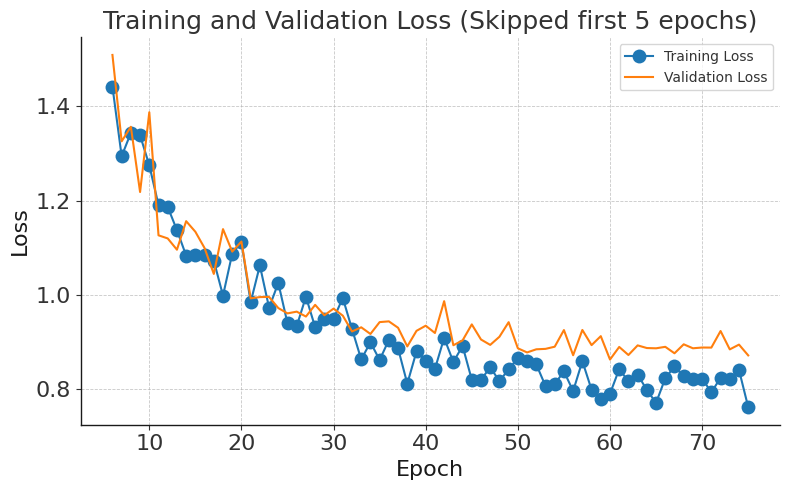

In [14]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

else:
    # Load model and set to CPU
    model_filename = "nn_model_2025-07-30_east_west_split.pt"  # Replace with actual date if needed

    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

In [12]:
# Load model and set to CPU
model_filename = "nn_model_2025-07-14_CH_flexible.pt"  # Replace with actual date if needed

loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Load model and make predictions:

In [13]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

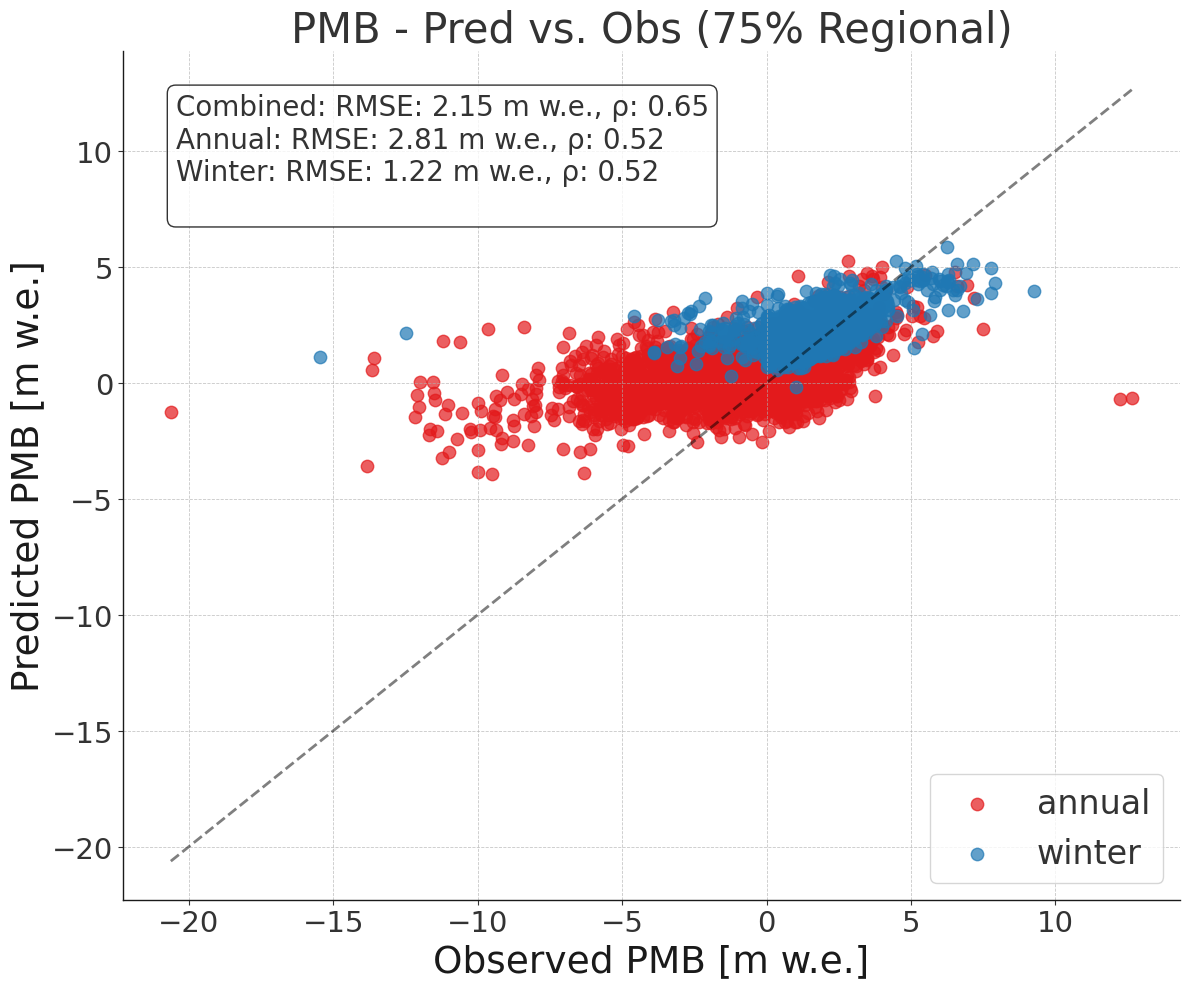

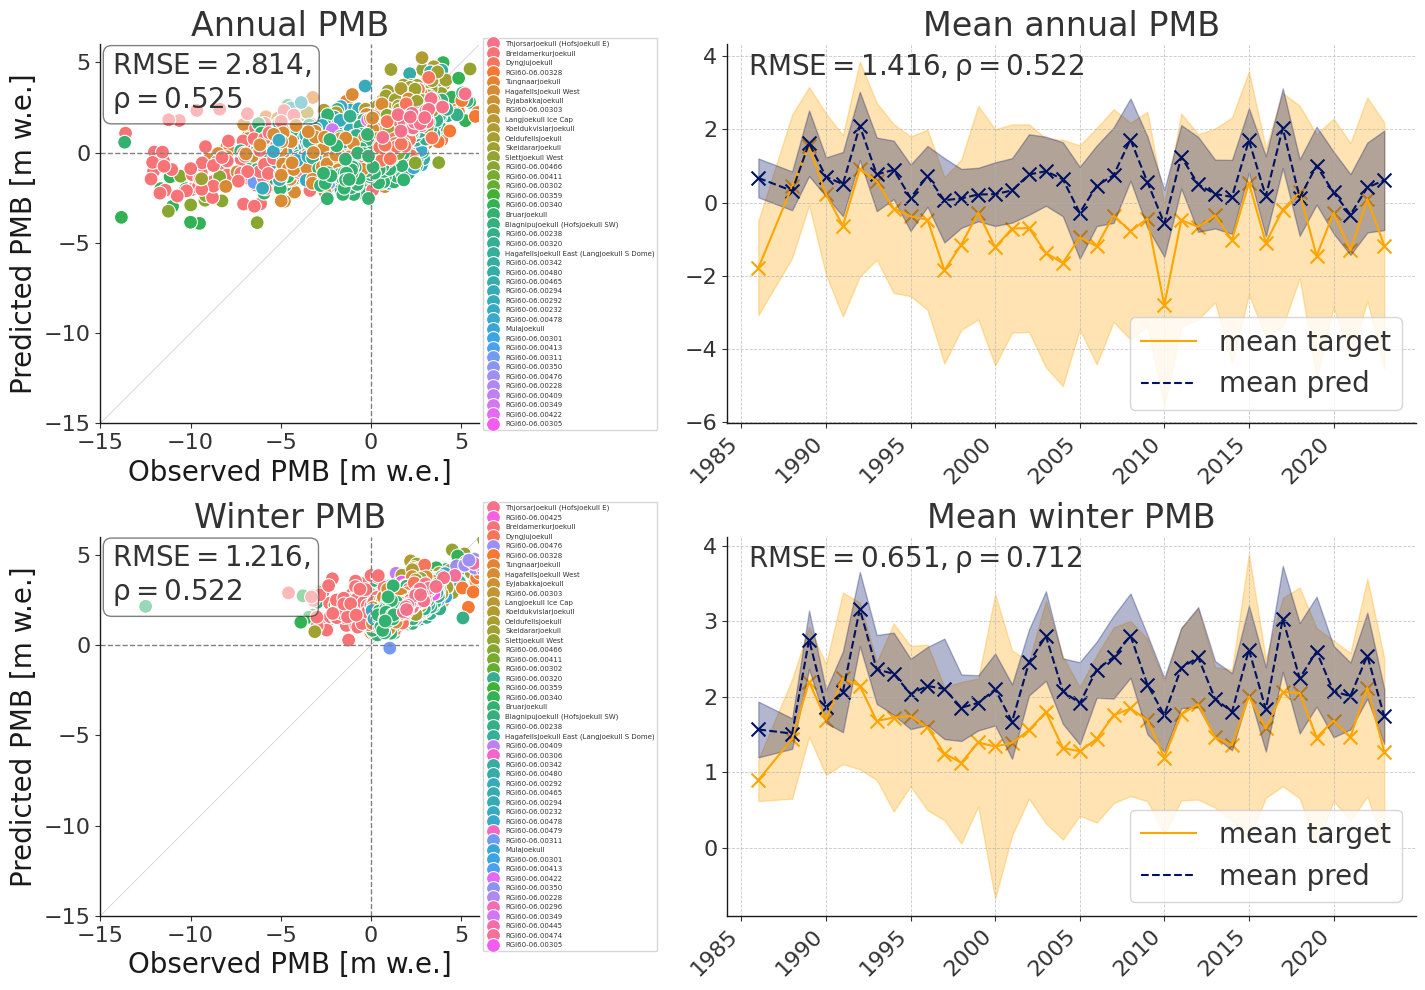

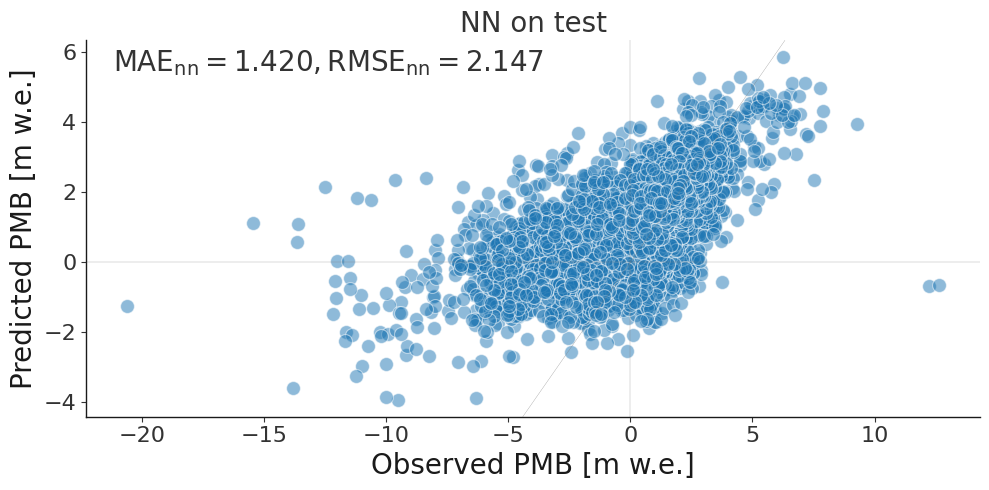

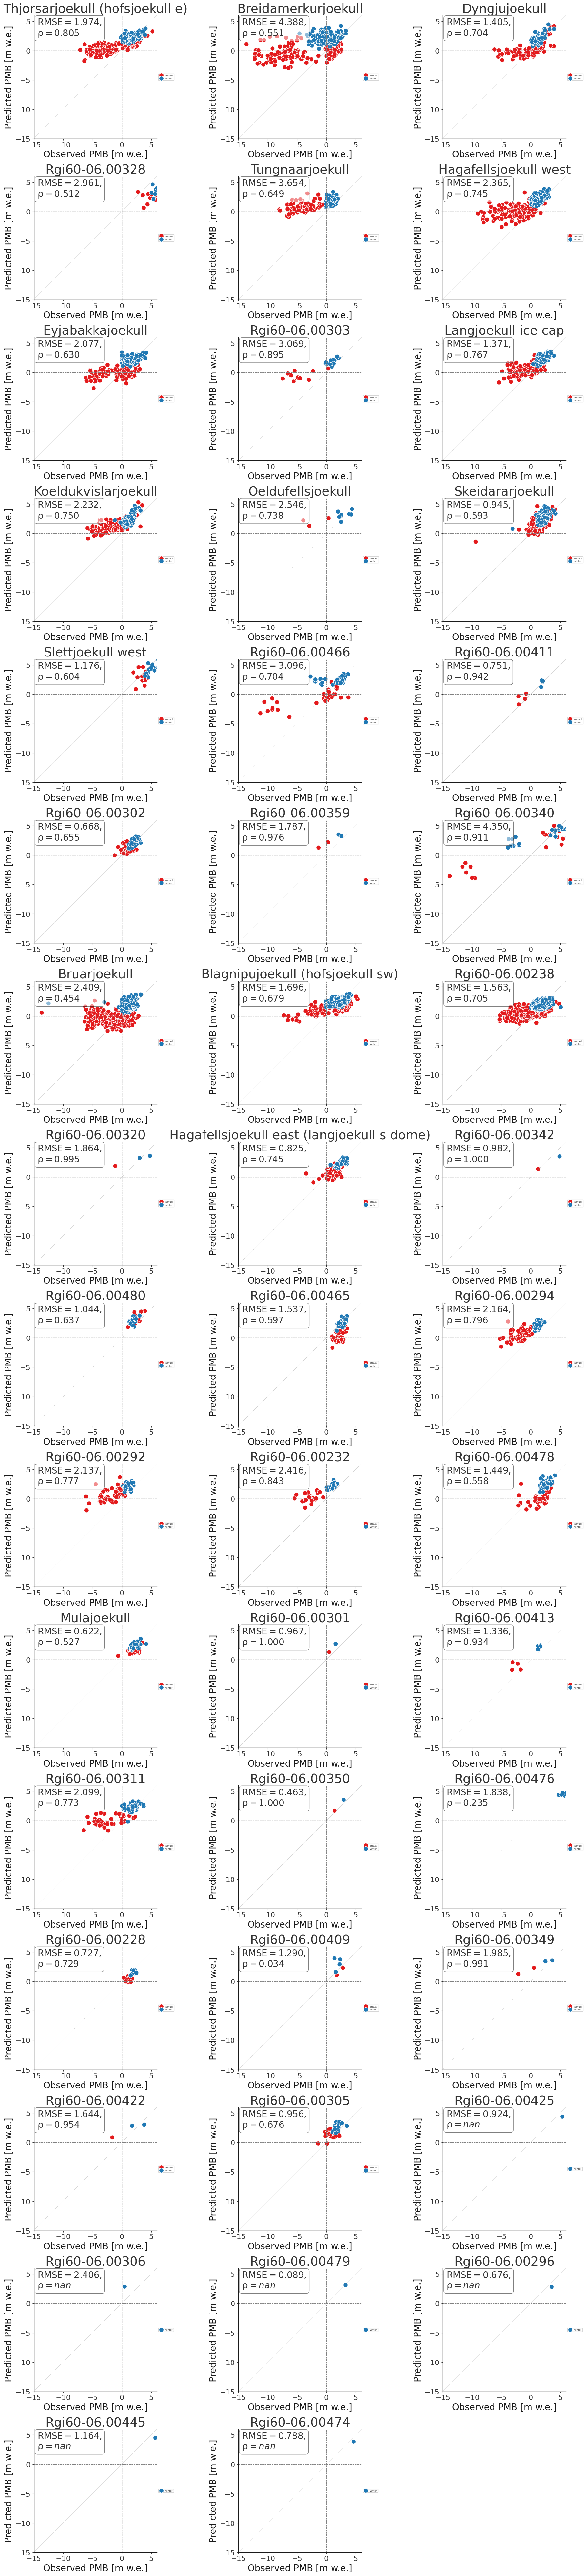

In [ ]:
PlotPredictionsCombined_NN(grouped_ids, region_name='CH Train ICE Test', include_summer=False)
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [14]:
# DANN components: Gradient Reversal, network, regressor wrapper, and dataset bindings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skorch.utils import to_tensor
import massbalancemachine as mbm
from pathlib import Path

# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradReverse(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class DANNNetwork(nn.Module):
    """
    Feature extractor identical to FlexibleNetwork's trunk, with two heads:
    - Regressor head for SMB (label)
    - Domain classifier head (binary)
    """
    def __init__(self, input_dim, hidden_layers, dropout=0.2, use_batchnorm=False, domain_hidden=64, grl_lambda=1.0):
        super().__init__()
        layers = []
        current_dim = input_dim
        if not isinstance(dropout, list):
            dropout = [dropout] * len(hidden_layers)
        for hidden_dim, drop_rate in zip(hidden_layers, dropout):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            current_dim = hidden_dim
        # trunk outputs the last hidden representation
        self.feature_extractor = nn.Sequential(*layers)
        # heads
        self.regressor = nn.Linear(current_dim, 1)
        self.grl = GradReverse(lambda_=grl_lambda)
        self.domain_classifier = nn.Sequential(
            nn.Linear(current_dim, domain_hidden),
            nn.ReLU(),
            nn.Dropout(dropout[-1] if isinstance(dropout, list) else dropout),
            nn.Linear(domain_hidden, 1),  # logits
        )

    def forward(self, x):
        h = self.feature_extractor(x)
        y_pred = self.regressor(h)
        d_logits = self.domain_classifier(self.grl(h))
        return y_pred, d_logits

# Dataset that yields domain labels padded per ID to match monthly padding
class DomainTargetDataset(torch.utils.data.Dataset):
    def __init__(self, aggregated_dataset):
        self.base = aggregated_dataset
        self.meta_has_domain = 'DOMAIN' in self.base.metadataColumns
        if not self.meta_has_domain:
            # fallback: try to read from features
            assert 'DOMAIN' in self.base.cfg.featureColumns, "DOMAIN must be in metadata or featureColumns"
            self.domain_feat_idx = self.base.cfg.featureColumns.index('DOMAIN')
        else:
            self.domain_idx = self.base.metadataColumns.index('DOMAIN')
    def __len__(self):
        return len(self.base)
    def __getitem__(self, index):
        ind = self.base._getInd(index)
        if self.meta_has_domain:
            dval = self.base.metadata[ind[0]][self.domain_idx]
        else:
            dval = self.base.features[ind[0], self.domain_feat_idx]
        dpad = np.empty(self.base.maxConcatNb, dtype=np.float32)
        dpad.fill(np.nan)
        dpad[:len(ind)] = dval
        return dpad

# Binding that returns (X, (y, d)) so y_true in get_loss can contain both
class CombinedTargetBinding(torch.utils.data.Dataset):
    def __init__(self, X_slice, y_slice, d_dataset):
        self.X = X_slice
        self.y = y_slice
        self.d = d_dataset
        assert len(self.X) == len(self.y) == len(self.d)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], (self.y[idx], self.d[idx])

# Skorch regressor that adds domain-adversarial loss on top of the SMB loss
class CustomDANNRegressor(mbm.models.CustomNeuralNetRegressor):
    def __init__(self, cfg, *args, dan_lambda=0.1, **kwargs):
        super().__init__(cfg, *args, **kwargs)
        self.dan_lambda = dan_lambda
        self._last_domain_logits = None

    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if len(x.shape) == 1:
            x = x[None]
        x, indNonNan = self._unpack_inp(x)
        if self.modelDtype is not None:
            x = x.type(self.modelDtype)
        outputs = self.module_(x, **fit_params)
        if isinstance(outputs, tuple):
            y_monthly, d_monthly = outputs
            y_packed = self._pack_out(y_monthly, indNonNan)
            d_packed = self._pack_out(d_monthly, indNonNan)
            self._last_domain_logits = d_packed
            return y_packed
        else:
            return self._pack_out(outputs, indNonNan)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        # y_true can be (label_pad, domain_pad) from CombinedTargetBinding
        if isinstance(y_true, (tuple, list)) and len(y_true) == 2:
            y_true_labels, y_true_domain = y_true
        else:
            y_true_labels, y_true_domain = y_true, None

        # Label loss (same as base implementation)
        loss = 0.0
        cnt = 0
        for yi_pred, yi_true in zip(y_pred, y_true_labels):
            valid = ~torch.isnan(yi_pred)
            if valid.any():
                pred_sum = yi_pred[valid].sum()
                true_mean = yi_true[valid].mean()
                loss = loss + (pred_sum - true_mean) ** 2
                cnt += 1
        label_loss = loss / max(cnt, 1)

        # Domain loss (optional during training)
        """"
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits
            mask = ~torch.isnan(y_true_domain)
            if mask.any():
                domain_loss = F.binary_cross_entropy_with_logits(d_logits[mask], y_true_domain[mask].float())
        """
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean, otherwise IDs with longer months have higher domain loss
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # shape: [batch, max_months] (or [batch, max_months, 1])
            per_id_losses = []
            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                # squeeze trailing dim if present
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                # mask valid months
                mask = ~torch.isnan(d_true_row) # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    per_id_losses.append(loss_i)

            if len(per_id_losses) > 0:
                domain_loss = torch.stack(per_id_losses).mean()  # mean over IDs
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean for each domain
        # otherwise IDs with longer months have higher domain loss and CH domain loss with more data is exaggerated
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # [batch_ids, max_months(,1)]
            per_id_losses_ch, per_id_losses_nor = [], [] # track losses separately, so we can average them individually later

            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                mask = ~torch.isnan(d_true_row)  # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    # domain for this ID (same across valid months)
                    dom_i = int(d_true_row[mask][0].item())  # 0=CH, 1=NOR
                    (per_id_losses_ch if dom_i == 0 else per_id_losses_nor).append(loss_i)

            parts = []
            if len(per_id_losses_ch) > 0:
                parts.append(torch.stack(per_id_losses_ch).mean())
            if len(per_id_losses_nor) > 0:
                parts.append(torch.stack(per_id_losses_nor).mean())
            if len(parts) > 0:
                domain_loss = torch.stack(parts).mean()

        return label_loss + self.dan_lambda * domain_loss

    @staticmethod
    def load_model(cfg, fname: str, *args, **kwargs):
        """Loads a pre-trained DANN model from a file."""
        model = CustomDANNRegressor(cfg, *args, **kwargs)
        model.initialize()
        models_dir = Path("./models")
        model.load_params(f_params=models_dir / fname)
        return model

params_dann = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
    'module__domain_hidden': 64,
    'module__grl_lambda': 1.0,
}

# Use DANN network
args_dann = {
    'module': DANNNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params_dann['module__dropout'],
    'module__hidden_layers': params_dann['module__hidden_layers'],
    'module__use_batchnorm': params_dann['module__use_batchnorm'],
    'module__domain_hidden': params_dann['module__domain_hidden'],
    'module__grl_lambda': params_dann['module__grl_lambda'],
    'train_split': my_train_split,
    'batch_size': params_dann['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params_dann['lr'],
    'max_epochs': 200,
    'optimizer': params_dann['optimizer'],
    'optimizer__weight_decay': params_dann['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

Loading Regional Baseline: nn_model_2025-08-21_5-10%_regional_baseline.pt
Loading CH and Regional Baseline: nn_model_2025-08-23_5-10%_CH_and_5-10%_baseline_only_ICE_val.pt
Loading Fine-tuning: nn_model_finetuned_2025-08-23_5-10%_fine_tuning_lr0.005_epoch_20.pt
Loading Batchnorm Unfrozen: nn_model_finetuned_2025-08-23_5-10%_batchnorm_unfrozen_linear_frozen_lr0.1_epoch200.pt
Loading DANN: dann_model_2025-08-23_5-10%_lamba0_01_mean_domainloss_even_domainloss_only_ICE_val_50_50epochsplit.pt


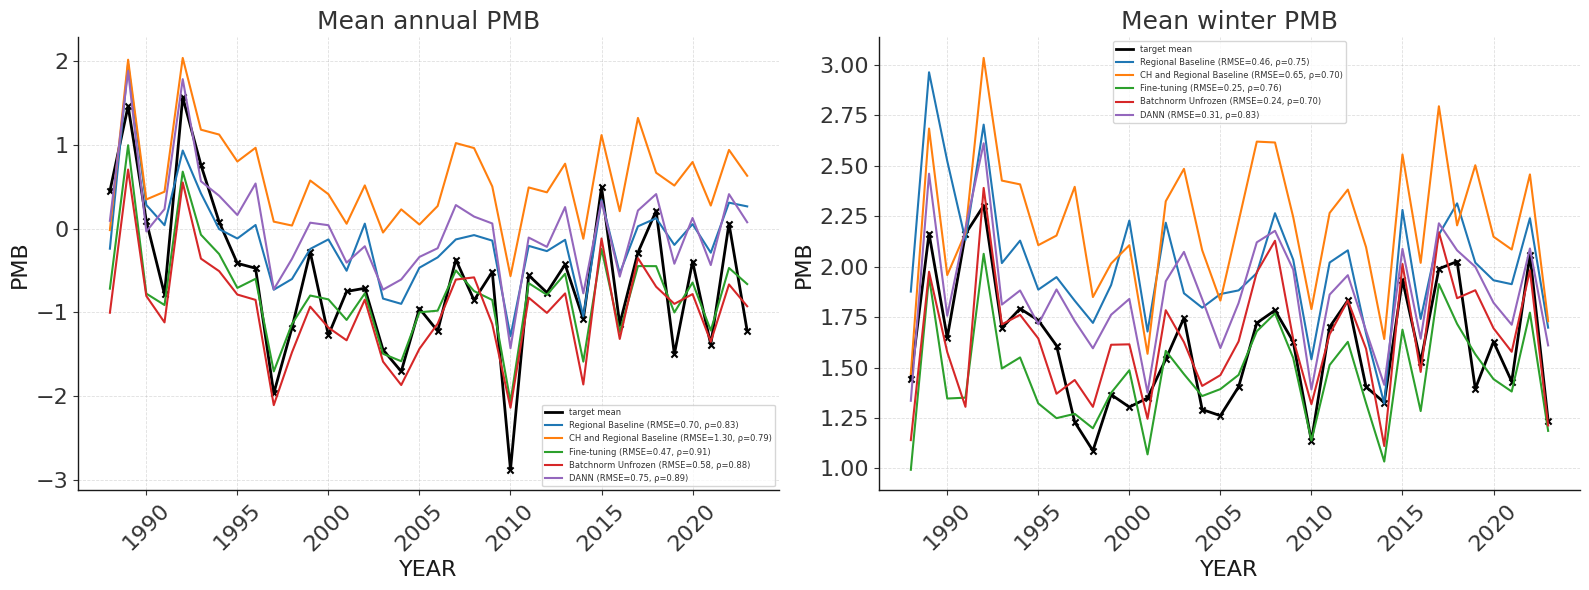

In [15]:
def plot_mean_pmb_multi(models_grouped, title_prefix='Mean PMB'):
    """
    models_grouped: dict[str -> DataFrame] where each DF has columns
      ['target','ID','pred','PERIOD','GLACIER','YEAR'] as returned by loader above.
    """
    # Use the first model’s DF as reference for ground-truth shading (same targets for all)
    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()

    # Prepare figure
    fig, (ax_ann, ax_win) = plt.subplots(1, 2, figsize=(16, 6))
    ax_ann.set_title('Mean annual PMB', fontsize=18)
    ax_win.set_title('Mean winter PMB', fontsize=18)

    # Colors for models
    palette = sns.color_palette("tab10", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho

    # Helper to plot one panel (annual or winter)
    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())

        # Ground-truth mean line (black)
        tgt_mean = df_period.groupby('YEAR')['target'].mean().reindex(years)
        ax.plot(years, tgt_mean, color="black", label="target mean", linewidth=2)
        ax.scatter(years, tgt_mean, color="black", marker='x', s=20)

        # Plot each model’s mean prediction per year and compute metrics (per period)
        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean().reindex(years)

            # Compute RMSE and Pearson r for this period (use per-ID means)
            metrics_df = pd.DataFrame({
                'YEAR': years,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            ).rename(columns={'target': 'target'})
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            ax.plot(years, pred_mean, label=label_with_metrics,
                    color=label_to_color.get(label, None), linestyle='-')
            #ax.scatter(years, pred_mean, color=label_to_color.get(label, None), s=15)

        ax.set_xlabel('YEAR')
        ax.set_ylabel('PMB')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize=6, loc='best')

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')

    plt.tight_layout()
    plt.show()


base = grouped_ids[['ID', 'target', 'PERIOD', 'GLACIER', 'YEAR']].copy()

# List models (optionally mix NN and DANN). Provide up to 5.
"""
#50%
models = [
    #('CH Baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Regional Baseline',  'nn_model_2025-08-21_50%_regional_baseline.pt', mbm.models.CustomNeuralNetRegressor),
    ('CH and Regional Baseline',  'nn_model_2025-08-21_50%_CH_and_50%_baseline_only_ICE_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-08-23_50%_fine_tuning_lr0.005_epoch_15.pt', mbm.models.CustomNeuralNetRegressor),
    ('Batchnorm Unfrozen',  'nn_model_finetuned_2025-08-23_50%_batchnorm_unfrozen_linear_frozen_lr0.1_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-08-23_50%_lamba0_05_mean_domainloss_even_domainloss_only_ICE_val_50_50epochsplit.pt', CustomDANNRegressor),
]

"""
#5-10%
models = [
    #('CH Baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Regional Baseline',  'nn_model_2025-08-21_5-10%_regional_baseline.pt', mbm.models.CustomNeuralNetRegressor),
    ('CH and Regional Baseline',  'nn_model_2025-08-23_5-10%_CH_and_5-10%_baseline_only_ICE_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-08-23_5-10%_fine_tuning_lr0.005_epoch_20.pt', mbm.models.CustomNeuralNetRegressor),
    ('Batchnorm Unfrozen',  'nn_model_finetuned_2025-08-23_5-10%_batchnorm_unfrozen_linear_frozen_lr0.1_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-08-23_5-10%_lamba0_01_mean_domainloss_even_domainloss_only_ICE_val_50_50epochsplit.pt', CustomDANNRegressor),
]


device = 'cpu'
# Build loader args for plain NN (FlexibleNetwork) and DANN (DANNNetwork)
nn_loader_args = {**args, **param_init}
try:
    _ = DANNNetwork  # ensure defined (from the DANN cell below)
    dann_loader_args = {
        **{
            **args,
            'module': DANNNetwork,
            'module__domain_hidden': params.get('module__domain_hidden', 64),
            'module__grl_lambda': params.get('module__grl_lambda', 1.0),
        },
        'dan_lambda': 0.05,  # inference-only, safe if different from train
        **param_init,
    }
except NameError:
    dann_loader_args = None  # will raise a clear error if DANN is requested

models_grouped = {}

for label, fname, model_cls in models:
    print(f'Loading {label}: {fname}')
    # Pick correct architecture for this checkpoint
    if model_cls.__name__ == 'CustomDANNRegressor':
        if dann_loader_args is None:
            raise NameError("DANNNetwork not available. Run the DANN components cell before loading DANN models.")
        mdl = model_cls.load_model(cfg, fname, **dann_loader_args)
    else:
        mdl = model_cls.load_model(cfg, fname, **nn_loader_args)

    mdl = mdl.set_params(device=device).to(device)

    # Predict aggregated by measurement ID using the same dataset_test
    y_pred_agg = mdl.aggrPredict(dataset_test[0])

    assert len(y_pred_agg) == len(base), f'Length mismatch for {label}'
    gdf = base.copy()
    gdf['pred'] = y_pred_agg
    models_grouped[label] = gdf

# Plot mean annual and mean winter PMB for all models together
plot_mean_pmb_multi(models_grouped)

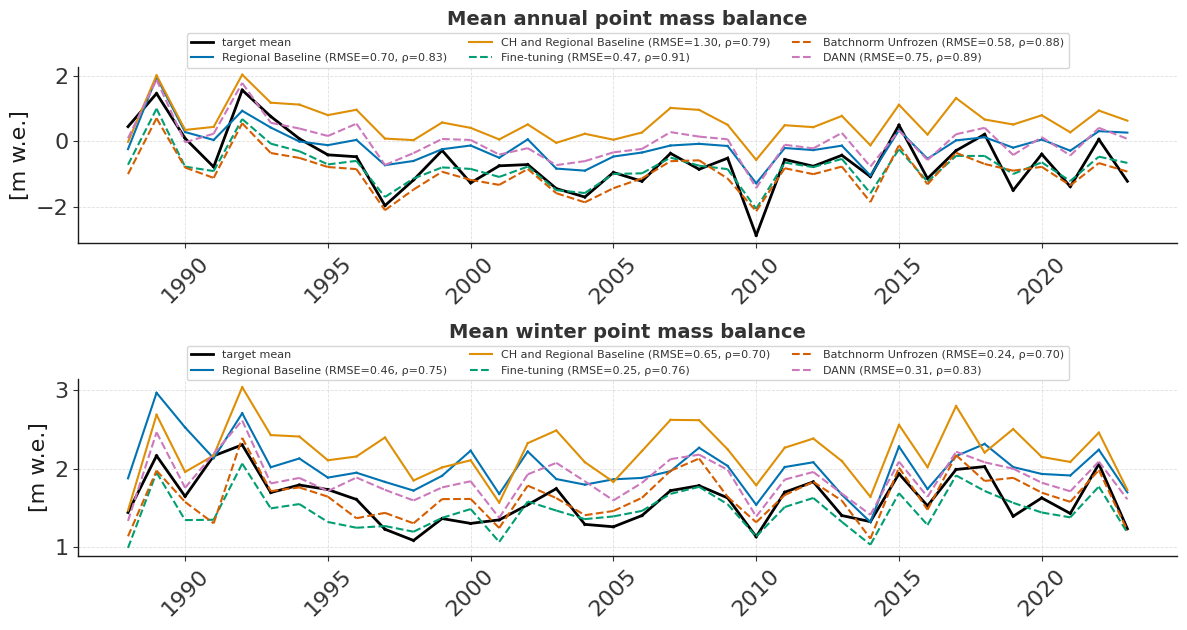

In [16]:
def plot_mean_pmb_multi_fixed_lines(models_grouped, title_prefix='Mean PMB'):

    # Use the first model's DF as reference for ground-truth shading (same targets for all)
    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()

    # Prepare figure
    fig, (ax_ann, ax_win) = plt.subplots(2, 1, figsize=(12, 8))  # Increased height more

    # Add titles to each subplot with more padding
    ax_ann.set_title('Mean annual point mass balance', fontsize=14, fontweight='bold', pad=30)
    ax_win.set_title('Mean winter point mass balance', fontsize=14, fontweight='bold', pad=30)

    # Colors for models
    palette = sns.color_palette("colorblind", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}

    # Define line styles for regional and transfer learning models
    regional_models = ['Regional Baseline', 'CH and Regional Baseline']
    transfer_models = ['Fine-tuning', 'Batchnorm Unfrozen', 'DANN']
    line_styles = {model: '-' for model in regional_models}  # Solid lines for regional models
    line_styles.update({model: '--' for model in transfer_models})  # Dashed lines for transfer models

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho

    # Helper to plot one panel (annual or winter)
    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())

        # Ground-truth mean line (black) - only connect consecutive years
        tgt_mean = df_period.groupby('YEAR')['target'].mean()
        available_years = tgt_mean.index.values
        available_values = tgt_mean.values
        
        # Plot line segments only between consecutive years with x markers
        target_line_plotted = False
        for i in range(len(available_years) - 1):
            if available_years[i+1] - available_years[i] == 1:  # consecutive years
                if not target_line_plotted:
                    # First line segment gets the label with line and x markers
                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6,
                           label="target mean")
                    target_line_plotted = True
                else:
                    # Subsequent segments without label but with x markers
                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6)
        
        # If no line was plotted (all isolated points), plot isolated points with x markers
        if not target_line_plotted:
            ax.plot(available_years, available_values, color="black", marker='x', markersize=6,
                   linestyle='None', label="target mean")

        # Plot each model's mean prediction per year and compute metrics (per period)
        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean()

            # Compute RMSE and R² for this period (use per-ID means)
            metrics_df = pd.DataFrame({
                'YEAR': pred_mean.index,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            )
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            
            # Plot line segments only between consecutive years
            pred_years = pred_mean.index.values
            pred_values = pred_mean.values
            
            label_added = False  # Track if we've added the label for this model
            
            for i in range(len(pred_years) - 1):
                if pred_years[i+1] - pred_years[i] == 1:  # consecutive years
                    ax.plot([pred_years[i], pred_years[i+1]], 
                           [pred_values[i], pred_values[i+1]], 
                           color=label_to_color.get(label, None), 
                           linestyle=line_styles.get(label, '-'),
                           label=label_with_metrics if not label_added else "")
                    label_added = True
            
            # If no consecutive years were found, add a dummy line for the legend
            if not label_added and len(pred_years) > 0:
                ax.plot([], [], 
                       color=label_to_color.get(label, None), 
                       linestyle=line_styles.get(label, '-'),
                       label=label_with_metrics)

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')

    # Add legends with much more spacing to avoid overlap
    ax_ann.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))
    ax_win.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))

    # Add y-axis labels
    ax_ann.set_ylabel('[m w.e.]')
    ax_win.set_ylabel('[m w.e.]')

    # Adjust layout to make space for the legends and titles
    plt.tight_layout(rect=(0, 0, 1, 0.8))  # Much more space at top
    plt.show()

plot_mean_pmb_multi_fixed_lines(models_grouped)

In [17]:
def create_model_comparison_table(models_grouped, periods=['annual', 'winter', 'combined']):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Define the desired order of models
    desired_order = [
        'Regional Baseline',
        'CH and Regional Baseline', 
        'Fine-tuning',
        'Batchnorm Unfrozen',
        'DANN'
    ]
    
    results = []
    
    # Process models in the desired order
    for model_name in desired_order:
        if model_name not in models_grouped:
            continue  # Skip if model not found
            
        df = models_grouped[model_name]
        # Filter out summer data (keep only annual and winter)
        df_filtered = df[df['PERIOD'].isin(['annual', 'winter'])].copy()
        
        # Calculate metrics for each period
        for period in periods:
            if period == 'combined':
                # Use all data (annual + winter)
                period_data = df_filtered
                period_label = 'Combined'
            else:
                # Use specific period data
                period_data = df_filtered[df_filtered['PERIOD'] == period]
                period_label = period.capitalize()
            
            if len(period_data) == 0:
                continue
                
            y_true = period_data['target'].values
            y_pred = period_data['pred'].values
            
            # Calculate metrics
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            r2 = r2_score(y_true, y_pred)
            rho = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
            
            results.append({
                'Model': model_name,
                'Period': period_label,
                'N_samples': len(period_data),
                'MAE': mae,
                'RMSE': rmse,
                'ρ': rho,
                'R²': r2,
                
            })
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    # Pivot table for better display
    metrics = ['N_samples', 'MAE', 'RMSE', 'ρ', 'R²']

    # Create a multi-index table
    pivot_tables = []
    for metric in metrics:
        pivot = results_df.pivot(index='Model', columns='Period', values=metric)
        pivot.name = metric
        pivot_tables.append(pivot)
    
    # Combine all metrics into one table with multi-level columns
    combined_table = pd.concat(pivot_tables, axis=1, keys=metrics)
    
    # Reorder the index (models) to maintain desired order
    combined_table = combined_table.reindex(desired_order)
    
    # Reorder columns to have Combined, Annual, Winter for each metric
    if 'Combined' in combined_table.columns.get_level_values(1):
        period_order = ['Combined', 'Annual', 'Winter']
    else:
        period_order = ['Annual', 'Winter']
    
    # Reorder columns
    new_columns = []
    for metric in metrics:
        for period in period_order:
            if (metric, period) in combined_table.columns:
                new_columns.append((metric, period))
    
    combined_table = combined_table[new_columns]
    
    # Round numerical values for better display
    numeric_metrics = ['MAE', 'RMSE', 'ρ', 'R²']
    for metric in numeric_metrics:
        for period in period_order:
            if (metric, period) in combined_table.columns:
                combined_table[(metric, period)] = combined_table[(metric, period)].round(3)
    
    return combined_table

def display_model_comparison_table(models_grouped):
    """
    Display a nicely formatted comparison table for all models.
    """
    table = create_model_comparison_table(models_grouped)
    
    print("="*80)
    print("MODEL PERFORMANCE COMPARISON TABLE")
    print("="*80)
    print()
    
    # Display the table
    print(table.to_string())
    
    print()
    print("Metrics explanation:")
    print("- N_samples: Number of data points")
    print("- MAE: Mean Absolute Error [m w.e.]")
    print("- RMSE: Root Mean Square Error [m w.e.]") 
    print("- R²: Coefficient of determination")
    print("- ρ: Pearson correlation coefficient")
    print("="*80)
    
    return table

# Generate and display the comparison table
comparison_table = display_model_comparison_table(models_grouped)

# Optionally, save to CSV
comparison_table.to_csv('5-10%_model_comparison.csv')

MODEL PERFORMANCE COMPARISON TABLE

                         N_samples                    MAE                   RMSE                      ρ                     R²              
Period                    Combined Annual Winter Combined Annual Winter Combined Annual Winter Combined Annual Winter Combined Annual Winter
Model                                                                                                                                       
Regional Baseline             5468   2654   2814    1.141  1.445  0.855    1.593  1.943  1.171    0.828  0.816  0.661    0.591  0.553  0.068
CH and Regional Baseline      5468   2654   2814    1.187  1.552  0.842    1.655  2.067  1.138    0.850  0.841  0.641    0.558  0.494  0.119
Fine-tuning                   5468   2654   2814    0.753  1.011  0.509    1.144  1.417  0.805    0.896  0.887  0.757    0.789  0.762  0.559
Batchnorm Unfrozen            5468   2654   2814    0.801  1.062  0.555    1.198  1.487  0.839    0.895  0.886  0.737 

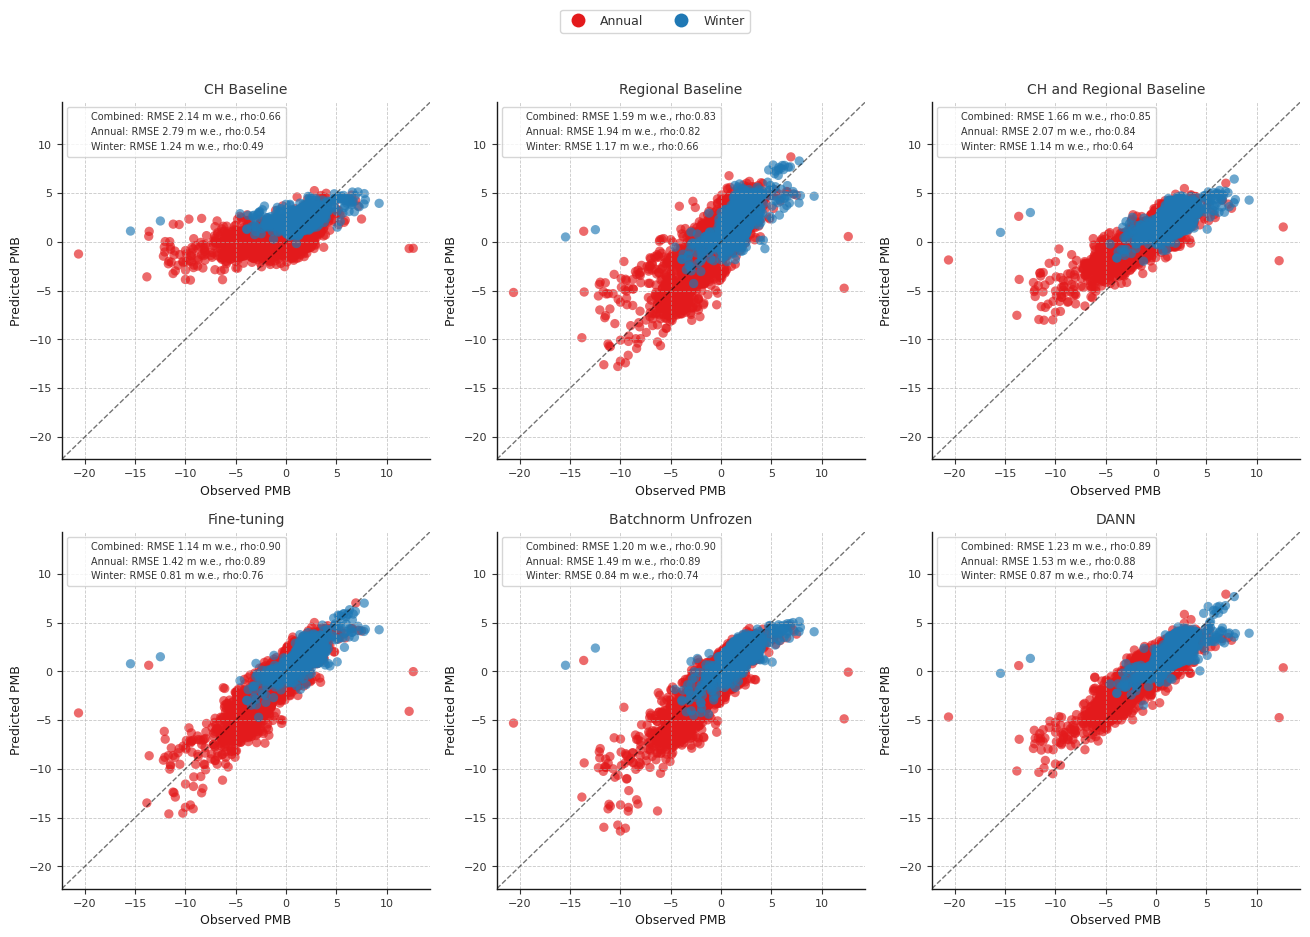

In [18]:
def plot_pred_vs_obs_grid(models_grouped, ncols=3, point_size=45, region_name='CH->FR'):
    """
    Grid of scatter plots (Observed vs Predicted) per model.
    Summer excluded.
    Global legend: Annual points, Winter points.
    Per‑subplot legend: 1:1 line + Combined/Annual/Winter metrics.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    period_colors = {'annual': '#e31a1c', 'winter': '#1f78b4'}
    labels = list(models_grouped.keys())
    n_models = len(labels)
    ncols_eff = min(ncols, n_models)
    nrows = int(np.ceil(n_models / ncols_eff))

    # Global axis limits
    all_targets = np.concatenate([models_grouped[l].target.values for l in labels])
    all_preds   = np.concatenate([models_grouped[l].pred.values   for l in labels])
    gmin = np.nanmin([all_targets.min(), all_preds.min()])
    gmax = np.nanmax([all_targets.max(), all_preds.max()])
    pad = 0.05 * (gmax - gmin)
    gmin -= pad
    gmax += pad

    fig, axes = plt.subplots(nrows, ncols_eff,
                             figsize=(4.4 * ncols_eff, 4.6 * nrows),
                             squeeze=False)
    metrics_all = {}

    for i, label in enumerate(labels):
        r, c = divmod(i, ncols_eff)
        ax = axes[r][c]
        df_plot = models_grouped[label]
        df_plot = df_plot[df_plot.PERIOD.isin(['annual','winter'])].copy()

        # Metrics per period
        panel_metrics = {}
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                y_t = sub.target.values
                y_p = sub.pred.values
                rmse = np.sqrt(np.mean((y_p - y_t)**2))
                rho  = np.corrcoef(y_t, y_p)[0,1] if len(sub) > 1 else np.nan
                panel_metrics[period] = (rmse, rho)

        # Combined
        y_t_all = df_plot.target.values
        y_p_all = df_plot.pred.values
        rmse_all = np.sqrt(np.mean((y_p_all - y_t_all)**2))
        rho_all  = np.corrcoef(y_t_all, y_p_all)[0,1] if len(df_plot) > 1 else np.nan
        panel_metrics['combined'] = (rmse_all, rho_all)
        metrics_all[label] = panel_metrics

        # Scatter (no per‑subplot point handles; handled globally)
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                ax.scatter(sub.target, sub.pred,
                           s=point_size, alpha=0.65, edgecolor='none',
                           color=period_colors[period])

        # 1:1 line + handle for subplot legend
        ax.plot([gmin,gmax],[gmin,gmax],'k--',linewidth=1,alpha=0.55)

        # Metric legend entries
        def metric_handle(name, key):
            rmse, rho = panel_metrics[key]
            return Line2D([],[], linestyle='',
                          label=f"{name}: RMSE {rmse:.2f} m w.e., rho:{rho:.2f}",
                          color='none')

        metric_handles = [
            metric_handle("Combined", 'combined'),
            *( [metric_handle("Annual", 'annual')] if 'annual' in panel_metrics else [] ),
            *( [metric_handle("Winter", 'winter')] if 'winter' in panel_metrics else [] ),
        ]

        ax.set_xlim(gmin,gmax)
        ax.set_ylim(gmin,gmax)
        ax.set_title(label, fontsize=10)
        ax.tick_params(labelsize=8)
        ax.set_xlabel('Observed PMB', fontsize=9)
        ax.set_ylabel('Predicted PMB', fontsize=9)

        # Subplot legend: only 1:1 + metrics
        ax.legend(handles=metric_handles,
                  fontsize=7, loc='upper left',
                  frameon=True, handlelength=1.2, borderpad=0.5)

    # Hide unused axes
    for j in range(n_models, nrows * ncols_eff):
        r, c = divmod(j, ncols_eff)
        axes[r][c].axis('off')

    # Global legend for point types (annual / winter)
    global_point_handles = [
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['annual'],
               label='Annual'),
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['winter'],
               label='Winter')
    ]
    fig.legend(handles=global_point_handles,
               loc='upper center',
               ncol=2,
               frameon=True,
               fontsize=9,
               bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=(0,0,1,0.95))
    return metrics_all

pred_grid_metrics = plot_pred_vs_obs_grid(models_grouped, ncols=3, region_name='CH->ICE')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def PlotIndividualGlacierPredVsTruth_Multi(models_grouped, base_figsize=(20, 15), height_per_row=5, ncols_models=2):
    
    # Get unique glaciers from the first model (should be same for all)
    first_model = next(iter(models_grouped.values()))
    unique_glaciers = first_model['GLACIER'].unique()
    n_glaciers = len(unique_glaciers)
    
    # Color palette for periods
    color_palette_period = {
        'annual': '#e31a1c',
        'winter': '#1f78b4'
    }
    
    # Calculate subplot layout
    n_models = len(models_grouped)
    ncols_total = min(ncols_models, n_models)
    nrows_models = int(np.ceil(n_models / ncols_total))
    
    # Create figure with subplots for each glacier
    fig = plt.figure(figsize=(base_figsize[0], n_glaciers * height_per_row))
    
    for glacier_idx, glacier_name in enumerate(unique_glaciers):
        # Create a grid for this glacier's models
        for model_idx, (model_name, model_df) in enumerate(models_grouped.items()):
            
            # Calculate subplot position
            subplot_idx = glacier_idx * n_models + model_idx + 1
            ax = plt.subplot(n_glaciers, n_models, subplot_idx)
            
            # Filter data for this glacier
            df_gl = model_df[model_df['GLACIER'] == glacier_name].copy()
            
            if len(df_gl) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{glacier_name}\n{model_name}', fontsize=12)
                continue
            
            # Calculate metrics including R²
            y_true = df_gl['target'].values
            y_pred = df_gl['pred'].values
            
            scores = {
                'mse': mean_squared_error(y_true, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'mae': mean_absolute_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred),
                'pearson_corr': np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
            }
            
            # Create scatter plot colored by period
            for period in df_gl['PERIOD'].unique():
                if period in color_palette_period:
                    period_data = df_gl[df_gl['PERIOD'] == period]
                    ax.scatter(period_data['target'], period_data['pred'], 
                             c=color_palette_period[period], 
                             label=period, alpha=0.7, s=50)
            
            # Add 1:1 line
            min_val = min(df_gl['target'].min(), df_gl['pred'].min())
            max_val = max(df_gl['target'].max(), df_gl['pred'].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)

            ax.set_aspect('equal', adjustable='box')
            
            # Add metrics text
            metrics_text = (f"RMSE: {scores['rmse']:.2f}\n"
                          f"MAE: {scores['mae']:.2f}\n" 
                          f"R²: {scores['r2']:.2f}\n"
                          f"ρ: {scores['pearson_corr']:.2f}")
            
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Set labels and title
            ax.set_xlabel('Observed PMB [m w.e.]', fontsize=11)
            ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=11)
            
            # Title shows glacier name for first model in row, model name for all
            if model_idx == 0:
                title = f'{glacier_name}\n{model_name}'
            else:
                title = model_name
            ax.set_title(title, fontsize=12)
            
            # Add legend only for first subplot of each glacier
            if model_idx == 0:
                ax.legend(fontsize=9, loc='lower right')
            
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

PlotIndividualGlacierPredVsTruth_Multi(models_grouped, base_figsize=(20, 15))